# 공사현장 안전 데이터 AI 해커톤 (2번)

- 작성된 환경: Window 11, Python 3.9, CUDA 11.8, Anaconda & Jupyter with VScode, PowerShell
- Google Colab 등의 클라우드 컴퓨팅 환경에서는 다른 동작을 할 가능성 있음

## 실행 전 사전 준비

- CMD 혹은 POWERSHELL에서
``` shell
git clone https://github.com/lukemelas/EfficientNet-PyTorch
cd EfficientNet-Pytorch
pip install -e .
```

- 데이터 파일을 root 경로(skeleton.ipynb가 있는 폴더)에 압축해제 해주세요<br>
<br>예시: <br><br>
root(industrial_safety_data_AI_Hackaton)<br>
&nbsp;ㄴ S63_DATA1-0.01<br>
&nbsp;&nbsp;ㄴ C1<br>
&nbsp;&nbsp;ㄴ G1<br>
&nbsp;&nbsp;ㄴ H1<br>
&nbsp;&nbsp;ㄴ I1<br>
&nbsp;&nbsp;ㄴ T1<br>

## 모듈 불러오기

In [14]:
import time
import copy
import random
import glob
import numpy as np
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## CUDA 코어 테스트 & 할당

In [15]:
print(torch.cuda.get_device_name())
print(torch.__version__)
print(torch.version.cuda)
x = torch.randn(1).cuda()
print(x)

NVIDIA GeForce GTX 1650
2.1.1
11.8
tensor([0.0400], device='cuda:0')


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 하이퍼 파라미터 (Hyper Parameter)
- 필요에 따라 수정(추가 및 삭제 가능)
- mean, standard deviation은 수정 비추천
- seed를 고정값으로 사용하면 커널을 초기화하고 다시 Run을해도 고정된 학습결과가 나타남. 테스트나 확인해야할 사항이 있을 때 seed 임의조절 가능. 랜덤하게 사용하고 싶다면 주석처리된 코드 이용.

In [17]:
params = {
  'img_size':224,
  'epoch': 10,
  'learning_rate': 0.05,
  'batch_size': 32,
  'seed': random.randrange(1, 10000000),
  'mean': [0.485, 0.456, 0.406],
  'std': [0.229, 0.224, 0.225],
  'workers': 6, # 본인 cpu 코어의 절반 정도
  'num_show_img': 5, # 데이터 확인 시 보여줄 데이터 개수
  'momentum': 0.9,
  'weight_decay': 1e-4,
}

## 이미지 확인 함수

In [18]:
def imgShow(input, title=None):
  """Img show for Tensor."""
  input = input.numpy().transpose((1,2,0))
  input = params['std'] * input + params['mean']
  input = np.clip(input, 0, 1)
  plt.imshow(input)
  if title is not None:
    plt.title(title)
  plt.pause(0.001) # pause a bit so that plots are updated

## Train 함수

In [19]:
def train_model(model, criterion, optimizer, scheduler, dataloaders: dict, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  train_loss, train_acc, valid_loss, valid_acc = [], [], [], []

  for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}'.format(epoch+1, num_epochs), end=": ")
    print('-'*10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'valid']:
      if phase =='train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode
      
      running_loss, running_corrects, num_cnt = 0.0, 0, 0

      count = 1
      one_percent = len(dataloaders[phase]) * 0.01
      percent = 0.0
      percent_ten = one_percent * 10
      #Iterate over data.
      for inputs, labels in dataloaders[phase]:
        if count > percent:
          if count > percent_ten:
            print("|", end="")
            percent_ten += one_percent * 10
          else:
            print("#", end="")
          percent += one_percent

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        num_cnt += len(labels)
        count += 1
      if phase == 'train':
        scheduler.step()
      
      epoch_loss = float(running_loss / num_cnt)
      epoch_acc = float((running_corrects.double() / num_cnt).cpu()*100)

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)
      else:
        valid_loss.append(epoch_loss)
        valid_acc.append(epoch_acc)
      print()
      print(f'{phase} Loss: {epoch_loss:.2f} Acc: {epoch_acc:.1f}')

      # deep copy the model
      if phase == 'valid' and epoch_acc > best_acc:
        best_idx = epoch
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
  
  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print('Best valid Acc: %d 0 %.1f'%(best_idx, best_acc))

  # load best model weights
  model.load_state_dict(best_model_wts)
  torch.save(model.state_dict(), 'industrial_model.pt')
  print('model saved')
  return model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc

## Efficientnet B0 모델 & 데이터 불러오기

In [20]:
# efficientnet-b0을 from_pretrained 메소드로 기 학습된 모델을 가져온다. (전이학습)
model_name = 'efficientnet-b0'
image_size = EfficientNet.get_image_size(model_name)
print(image_size)
model = EfficientNet.from_pretrained(model_name, num_classes=5)

random.seed(params['seed']) # 코드 테스트용, 랜덤 시드 고정
torch.manual_seed(params['seed'])

data_path = './S63_DATA1-001'
industrial_dataset = datasets.ImageFolder(
                      data_path,
                      transforms.Compose([
                        transforms.Resize((224, 224)), # efficientnet-b0 이미지 규격에 맞춤
                        transforms.ToTensor(), # 텐서화
                        transforms.Normalize(mean=params['mean'], std=params['std'])
                      ])) # 연구진들이 가장 최적화된 정규화 값을 찾음. 안정된 학습을 위한 데이터 정규화.

224
Loaded pretrained weights for efficientnet-b0


## 데이터를 Train:Valid:Test=8:1:1로 나누기

In [21]:
# train : valid : test = 8 : 1 : 1
train_idx, tmp_idx = train_test_split(list(range(len(industrial_dataset))), test_size=0.2, random_state=params['seed'])
data_sets = {}
data_sets['train'] = Subset(industrial_dataset, train_idx)
tmp_dataset = Subset(industrial_dataset, tmp_idx)

val_idx, test_idx = train_test_split(list(range(len(tmp_dataset))), test_size=0.5, random_state=params['seed'])
data_sets['valid'] = Subset(tmp_dataset, val_idx)
data_sets['test'] = Subset(tmp_dataset, test_idx)

## 데이터 로더 정의 & 사이즈 확인

In [22]:
# data loader
dataloaders, batch_num = {}, {}
dataloaders['train'] = DataLoader(data_sets['train'],
                                  batch_size=params['batch_size'],
                                  shuffle=True,
                                  num_workers=params['workers'])
dataloaders['valid'] = DataLoader(data_sets['valid'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
dataloaders['test'] = DataLoader(data_sets['test'],
                                  batch_size=params['batch_size'],
                                  shuffle=False,
                                  num_workers=params['workers'])
batch_num['train'], batch_num['valid'], batch_num['test'] = len(dataloaders['train']), len(dataloaders['valid']), len(dataloaders['test'])
print('batch_size : %d,  tvt : %d / %d / %d' % (params['batch_size'], batch_num['train'], batch_num['valid'], batch_num['test']))

batch_size : 32,  tvt : 750 / 94 / 94


## 데이터 확인

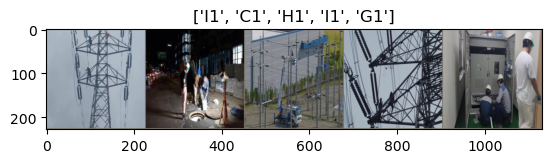

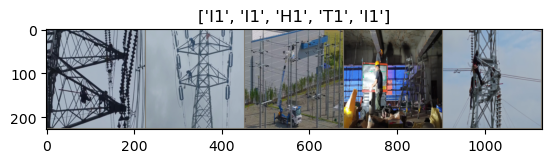

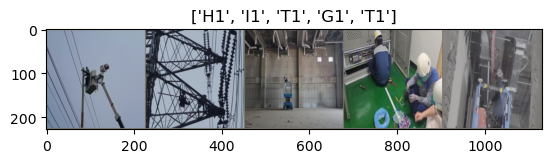

In [23]:
# 데이터 확인
class_names = {
  "0": "C1",
  "1": "G1",
  "2": "H1",
  "3": "I1",
  "4": "T1"
}

# train data
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# valid data
inputs, classes = next(iter(dataloaders['valid']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])
# test data
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs[:params['num_show_img']])
imgShow(out, title=[class_names[str(int(x))] for x in classes[:params['num_show_img']]])

## 모델을 장치로 할당

In [24]:
# setting
model = model.to(device)

# CUDA 확인
next(model.parameters()).is_cuda

True

## 손실함수 & 옵티마이저 설정

In [25]:
criterion = torch.nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(),
                                lr=params['learning_rate'],
                                momentum=params['momentum'],
                                weight_decay=params['weight_decay'])
lmbda = lambda epoch: 0.98739
exp_lr_scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer_ft, lr_lambda=lmbda)

## 학습 시작

In [26]:
model, best_idx, best_acc, train_loss, train_acc, valid_loss, valid_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, num_epochs=params['epoch'])


Epoch 1/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.01 Acc: 99.7
#########|########|#########|########|#########|########|########|#########|########|#########
valid Loss: 0.00 Acc: 100.0
==> best model saved - 0 / 100.0

Epoch 2/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.00 Acc: 100.0
#########|########|#########|########|#########|########|########|#########|########|#########
valid Loss: 0.00 Acc: 100.0

Epoch 3/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.00 Acc: 100.0
#########|########|#########|########|#########|########|########|#########|########|#########
valid Loss: 0.00 Acc: 100.0

Epoch 4/10: ----------
##########|#########|#########|#########|#########|#########|#########|#########|#########|#########
train Loss: 0.0

## 학습 결과 분석

best model : 0 - 100 / 0.0


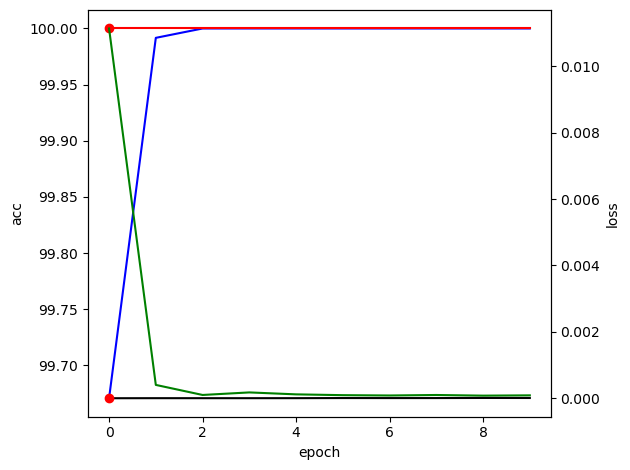

In [27]:
## 결과 그래프 그리기
print('best model : %d - %1.f / %.1f'%(best_idx, valid_acc[best_idx], valid_loss[best_idx]))
fig, ax1 = plt.subplots()

ax1.plot(train_acc, 'b-')
ax1.plot(valid_acc, 'r-')
plt.plot(best_idx, valid_acc[best_idx], 'ro')
ax1.set_xlabel('epoch')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('acc', color='k')
ax1.tick_params('y', colors='k')

ax2 = ax1.twinx()
ax2.plot(train_loss, 'g-')
ax2.plot(valid_loss, 'k-')
plt.plot(best_idx, valid_loss[best_idx], 'ro')
ax2.set_ylabel('loss', color='k')
ax2.tick_params('y', colors='k')

fig.tight_layout()
plt.show()

## 모델 TEST

In [28]:
def test_and_visualize_model(model, dataloaders, phase = 'test', num_images=4):
  # phase = 'train', 'valid', 'test'

  was_training = model.training
  model.eval()
  fig = plt.figure()

  running_loss, running_corrects, num_cnt = 0.0, 0, 0

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels) # batch의 평균 loss 출력

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      num_cnt += inputs.size(0) # batch size
    
    test_loss = running_loss / num_cnt
    test_acc = running_corrects.double() / num_cnt
    print('test done : loss/acc : %.2f / %.1f' % (test_loss, test_acc*100))
  
  # 예시 그림 출력
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders[phase]):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(1, num_images+1):
        ax = plt.subplot(num_images//2, 2, j)
        ax.axis('off')
        ax.set_title('%s : %s -> %s' %(
          'True' if class_names[str(labels[j].cpu().numpy())] == class_names[str(preds[j].cpu().numpy())] else 'False',
          class_names[str(labels[j].cpu().numpy())], 
          class_names[str(preds[j].cpu().numpy())]
        ))
        imgShow(inputs.cpu().data[j])
      
      if i == 0: break
  
  model.train(mode=was_training) # 다시 train모드로 전환

test done : loss/acc : 0.00 / 100.0


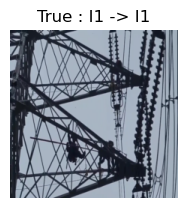

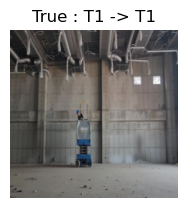

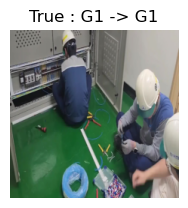

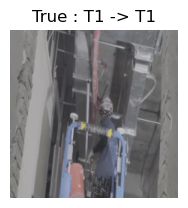

In [29]:
test_and_visualize_model(model, dataloaders, phase='test')

## GradCam을 통한 모델 세부 분석
- 추가 예정